In [3]:
from preprocessing import read_tfrecords

In [4]:
X,y = read_tfrecords()

2024-04-06 17:31:18.111758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]
2024-04-06 17:31:18.112129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]


In [256]:
X.shape


torch.Size([200, 64, 64, 12])

In [ ]:
X_test_fire = X[1,:,:,11]
X_test_wind = X[1,:,:,1]

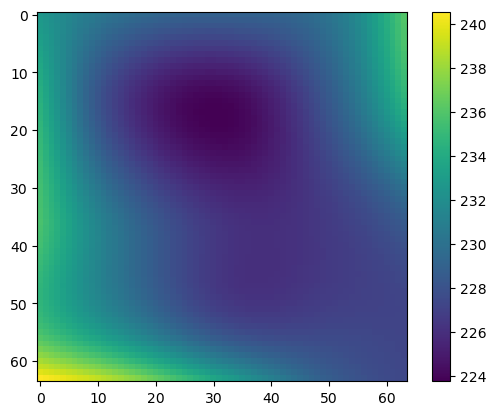

In [253]:
plt.imshow(X_test_fire)


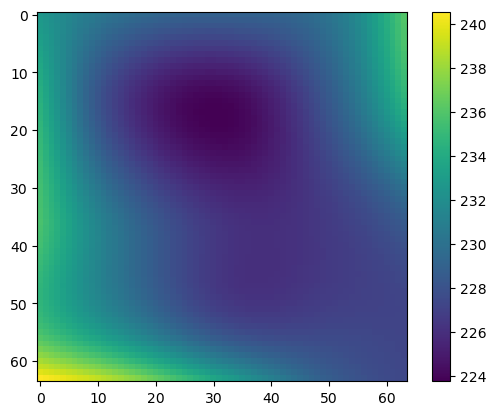

In [245]:
plt.imshow(X_test_wind)
plt.colorbar()

In [251]:
test = apply_cosine_similarity(X_test_fire,X_test_wind, calculate_cosine_similarity)

/var/folders/7l/yk4r99455ws31nbs3m733gx40000gn/T/ipykernel_27141/4165468669.py:10: RuntimeWarning: invalid value encountered in double_scalars
  cosine_similarity = np.dot(vec_to_point, vec_direction) / (np.linalg.norm(vec_to_point) * np.linalg.norm(vec_direction))


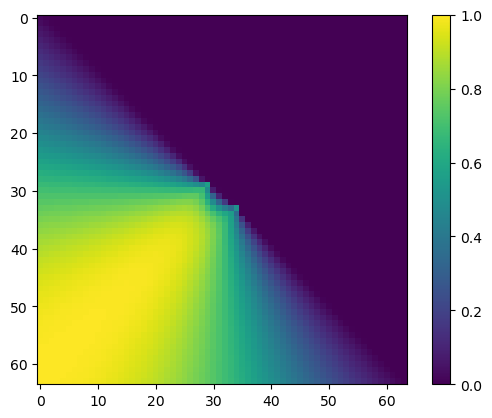

In [252]:
plt.imshow(test)
plt.colorbar()

In [205]:
import numpy as np

def calculate_cosine_similarity(x1, y1, x2, y2, direction_deg):
    # Calculate the vectors from the first datapoint to the second datapoint and the direction
    direction_deg = (180 - direction_deg) % 360
    vec_to_point = np.array([x2 - x1, y2 - y1])
    vec_direction = np.array([np.cos(np.radians(direction_deg)), np.sin(np.radians(direction_deg))])
    
    # Calculate the cosine similarity
    cosine_similarity = np.dot(vec_to_point, vec_direction) / (np.linalg.norm(vec_to_point) * np.linalg.norm(vec_direction))

    if (cosine_similarity <0):
        cosine_similarity = 0

    return cosine_similarity

# Example usage:
# First datapoint
x1 = 0
y1 = 0
direction_deg = 90  # Direction of the first datapoint in degrees

# Second datapoint
#x2, y2 = np.meshgrid(np.arange(64), np.arange(64))
x2 = 0
y2 = 400
# Calculate the normalized cosine similarity
similarity = calculate_cosine_similarity(x1, y1, x2, y2, direction_deg)

# Print the result
print("Normalized similarity:", similarity)


Normalized similarity: 1.0


Result Matrix:


/var/folders/7l/yk4r99455ws31nbs3m733gx40000gn/T/ipykernel_27141/4165468669.py:10: RuntimeWarning: invalid value encountered in double_scalars
  cosine_similarity = np.dot(vec_to_point, vec_direction) / (np.linalg.norm(vec_to_point) * np.linalg.norm(vec_direction))


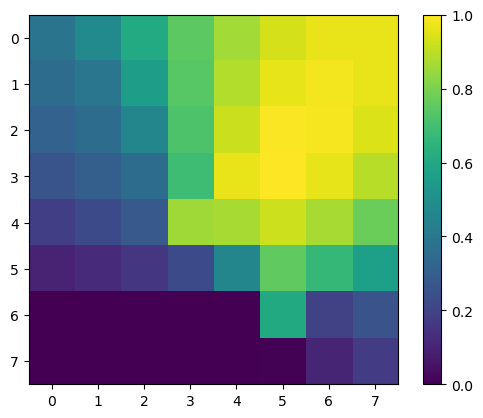

In [250]:
import numpy as np

def apply_cosine_similarity(firemask,direction_matrix2, func):
    # Find indices where m1 equals 1
    indices = np.argwhere(firemask == 1)

    res_list = list()

    for i, sublist in enumerate(indices):
        #x, y = np.meshgrid(np.arange(64), np.arange(64))
        x_f = sublist[0] # 0
        y_f = sublist[1] # 0
        wind_direction = direction_matrix2[x_f,y_f] # 45

        result = np.zeros((direction_matrix2.shape[0], direction_matrix2.shape[1]))

        for x in range(direction_matrix2.shape[0]):
            for y in range(direction_matrix2.shape[1]):
                res = func(x_f,y_f,x,y, wind_direction)
                result[x,y] = res
        result[np.isnan(result)] = 1
        res_list.append(result)

    sum_arrays = sum(res_list)
    min_val = np.min(sum_arrays)
    max_val = np.max(sum_arrays)

    normalized_array = (sum_arrays - min_val) / (max_val - min_val)
    
    return normalized_array
    

# Example matrices
m1 = np.array([[0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,1,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,1,0,0],
               [0, 0, 0,0,0,0,0,0]])

m2 = np.array([[0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,57,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0],
               [0, 0, 0,0,0,0,0,0]])

# Apply the function to matrices m1 and m2
direction = apply_cosine_similarity(m1, m2, calculate_cosine_similarity)

# Print the result
print("Result Matrix:")
plt.imshow(direction, cmap='viridis') 
plt.colorbar()

In [262]:
def add_fire_direction_to_tensor(
        tensor: torch.Tensor,
        wind_direction_index: int,
        fire_mask_index: int) -> torch.Tensor:

    fire_mask = tensor[:, :, :, fire_mask_index].numpy()
    wind_direction = tensor[:, :, :, wind_direction_index].numpy()

    tensor_shape = (64, 64, 1)
    fire_direction_final = torch.empty((tensor.shape[0],) + tensor_shape)

    for i in range(tensor.shape[0]):
        wind_influence = apply_cosine_similarity(fire_mask[i,:,:], wind_direction[i,:,:],calculate_cosine_similarity)
        wind_influence = torch.from_numpy(wind_influence)
        wind_influence = wind_influence.unsqueeze(-1) # Unsqueeze adds dimension m to make it compatible
        fire_direction_final[i] = wind_influence

    tensor = torch.cat([fire_direction_final, tensor], dim=-1)

    return tensor

In [263]:
tt = add_fire_direction_to_tensor(X,1,11)

/var/folders/7l/yk4r99455ws31nbs3m733gx40000gn/T/ipykernel_27141/4165468669.py:10: RuntimeWarning: invalid value encountered in double_scalars
  cosine_similarity = np.dot(vec_to_point, vec_direction) / (np.linalg.norm(vec_to_point) * np.linalg.norm(vec_direction))


In [271]:
import numpy as np

def apply_cosine_similarity(firemask, direction_matrix2, func):
    # Find indices where firemask equals 1
    indices = np.argwhere(firemask == 1)

    # Create an empty array to store results
    result = np.zeros_like(direction_matrix2)

    for i, idx in enumerate(indices):
        # Extract indices for current position
        x_f = idx[0] # 0
        y_f = idx[1] # 0

        # Extract wind direction for current index
        wind_direction = direction_matrix2[x_f, y_f]

        # Calculate similarities for each cell
        xx, yy = np.meshgrid(np.arange(direction_matrix2.shape[0]), np.arange(direction_matrix2.shape[1]))
        res = func(x_f, y_f, xx, yy, wind_direction)

        # Set NaN values to 1
        res[np.isnan(res)] = 1

        # Add the calculated similarity to the result
        result += res

    # Normalize the result
    min_val = np.min(result)
    max_val = np.max(result)
    normalized_array = (result - min_val) / (max_val - min_val)

    return normalized_array
